# Nazwa modelu


## Opis


In [ ]:
import os
import shutil
from pathlib import Path
import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import random
from torchvision.models import resnet18
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM



In [5]:
def load(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

SEED = 900729
dir_path = './data'
train_path = './data/Training'
test_path = './data/Testing'
validation_path = './data/Validation'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devic: {device}")

if os.path.exists(dir_path):
    print("Dane juz istnieją")
else:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('masoudnickparvar/brain-tumor-mri-dataset', path='./data', unzip=True)
    tr_orginal_df = load(train_path)
    ts_df = load(test_path)
    val_df, tr_df = train_test_split(tr_orginal_df, train_size=0.25, random_state=SEED, stratify=tr_orginal_df['Class'])
    validation_path = './data/Validation'
    Path(validation_path).mkdir(exist_ok=True)

    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for class_name in classes:
        class_validation_path = Path(validation_path) / class_name
        class_validation_path.mkdir(exist_ok=True)

    errors = []

    for idx, row in val_df.iterrows():
        try:
            source_path = Path(row['Class Path'])

            filename = source_path.name
            class_name = row['Class']
            destination_path = Path(validation_path) / class_name / filename

            shutil.move(str(source_path), str(destination_path))

        except Exception as e:
            errors.append({
                'file': row['Class Path'],
                'class': row['Class'],
                'error': str(e)
            })


    if errors:
        print(f"Errors: {len(errors)}")
        for error in errors:
            print(f"  - {error['class']}: {Path(error['file']).name} - {error['error']}")

    val_df_updated = val_df.copy()
    val_df_updated['Class Path'] = val_df_updated.apply(
        lambda row: str(Path(validation_path) / row['Class'] / Path(row['Class Path']).name),
        axis=1
    )

    tr_df_updated = load(train_path)

    val_df = val_df_updated
    tr_df = tr_df_updated
    print("Pomyślnie pobrano dane")



Devic: cpu
Dane juz istnieją


# 🧠 ResNet – Residual Network (Resztkowa Sieć Neuronowa)

### Opis

#### 🔹 Dlaczego powstał?
- Wraz ze wzrostem liczby warstw w sieciach neuronowych pojawił się problem:
  - **zanikający gradient** – trudność w trenowaniu bardzo głębokich sieci,
  - **degradacja dokładności** – dodawanie kolejnych warstw pogarszało wyniki zamiast je poprawiać.
- Klasyczne sieci (np. VGG) nie były w stanie efektywnie uczyć się przy setkach warstw.

#### 🔹 I wtedy powstał ResNet
- ResNet wprowadza **połączenia resztkowe (skip connections)**.
- Zamiast uczyć się bezpośredniej funkcji `H(x)`, sieć uczy się **reszty** względem wejścia:

\[
H(x) = F(x) + x
\]

gdzie:
- `x` – wejście do bloku,
- `F(x)` – transformacja (np. sploty, normalizacja, ReLU),
- `H(x)` – wyjście po dodaniu shortcutu.

Dzięki temu sieć łatwo uczy się nawet **funkcji tożsamościowej**, co stabilizuje trening.

#### 🔹 Jak działa blok resztkowy?
Schemat działania jednego **Residual Block**:

Wejście (x)<br>
↓<br>
[Conv -> BN -> ReLU -> Conv -> BN] = F(x)<br>
↓<br>
Dodanie shortcut: y = F(x) + x<br>
↓<br>
ReLU<br>
↓<br>
Wyjście (y)

- **Shortcut (skip connection)** może być:
  - *Identity* – gdy rozmiary się zgadzają,
  - *Conv 1x1* – gdy trzeba dopasować liczbę kanałów lub rozdzielczość.


### Architektura

<p align="center">
  <img src="./screenshots/resnet_architecture.png" alt="Resnet architecture">
</p>

## Base line

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
test_dataset  = datasets.ImageFolder(root=test_path, transform=data_transform)
val_dataset   = datasets.ImageFolder(root=validation_path, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 4284
    Root location: ./data/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 1428
    Root location: ./data/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 1311
    Root location: ./data/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [8]:
model = resnet18(pretrained=True) 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes)) 
model = model.to(device)

/Users/fidok/Developer/WakacyjneWyzwanieSOLVRO-ML/FinalProject/Brain_Tumor_Team_Projekt4/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fidok/Developer/WakacyjneWyzwanieSOLVRO-ML/FinalProject/Brain_Tumor_Team_Projekt4/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
EPOCHS = 10
if os.path.exists('best_model.pth'):
    model.load_state_dict(torch.load('best_model.pth'))
    print("Wczytano zapisany model")
else:
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")


Wczytano zapisany model


In [10]:
best_loss = float('inf')
model.eval()
val_loss = 0.0
with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

val_loss /= len(val_loader)
if val_loss < best_loss:
    best_loss = val_loss
    counter = 0
    torch.save(model.state_dict(), 'best_model.pth')

Test Loss: 0.0870
Test Accuracy: 96.72%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.91      0.96      0.93       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311


Confusion Matrix:


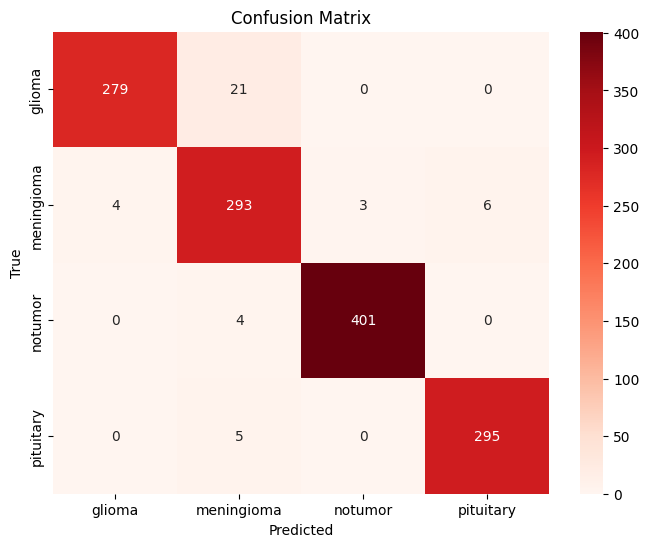

In [11]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Model osiąga dobre predykcje na zbiorze walidacyjnym lekko myli się z glejakiem przypisując mu oponiaka można to prawdopodobnie zrównoważyć podwyższając wage w zbiorze z glejakiem 

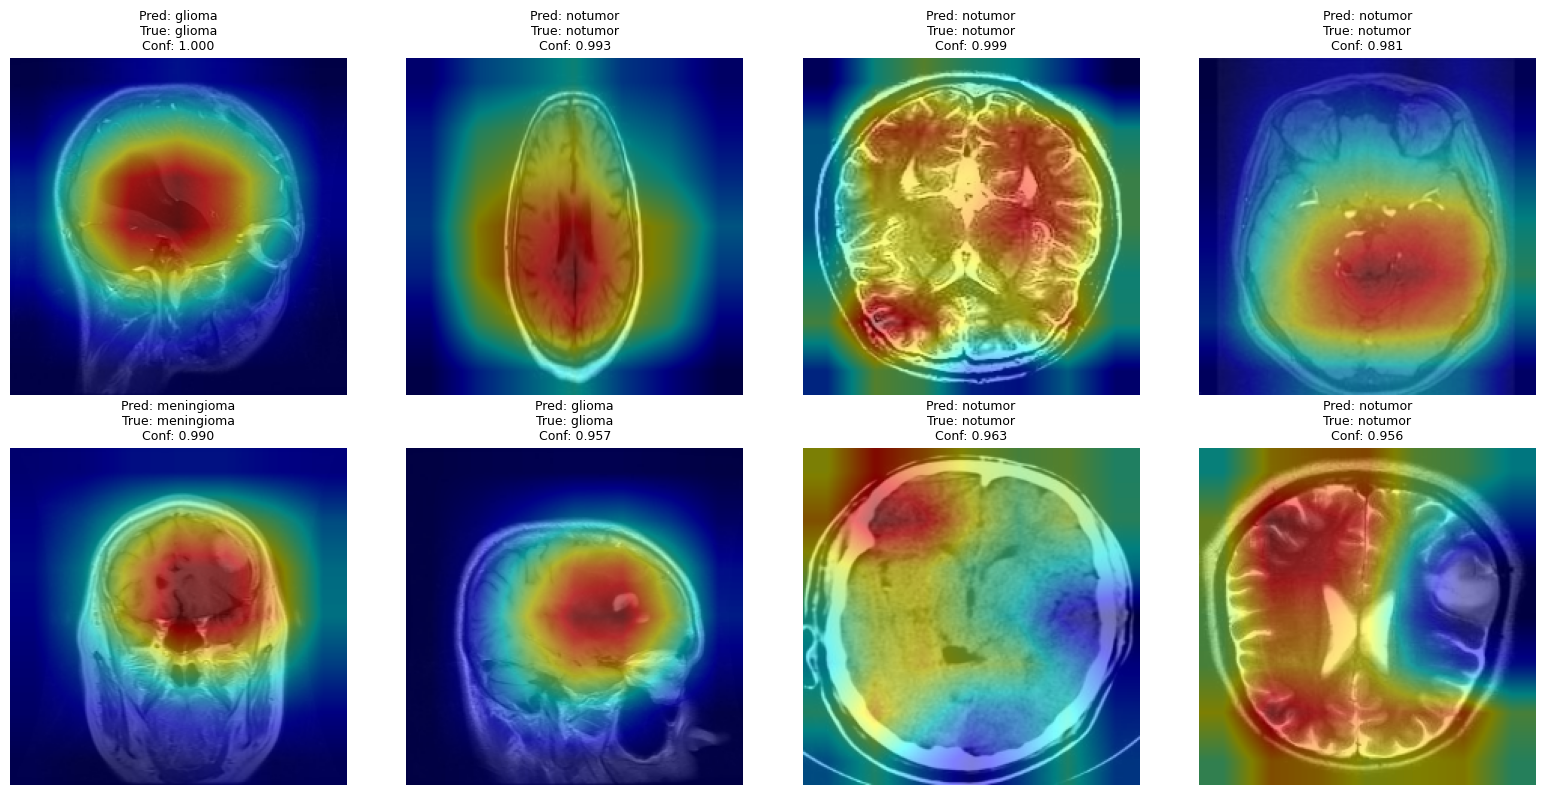

In [101]:
target_layers = [model.layer4[-1]]  # Ostatnia warstwa bloku resnetowego
cam = GradCAM(model=model, target_layers=target_layers)

# Wybierz 8 losowych próbek
samples = random.sample(test_dataset.samples, 8)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for ax, (img_path, true_label) in zip(axes.flatten(), samples):
    # Wczytaj i przygotuj obraz
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    rgb_img = np.float32(img_resized) / 255
    
    # Przygotuj tensora
    input_tensor = data_transform(Image.fromarray(img_resized)).unsqueeze(0).to(device)

    # Predykcja
    with torch.no_grad():
        outputs = model(input_tensor)
        predicted_class = outputs.argmax(dim=1).item()
        probabilities = F.softmax(outputs, dim=1)[0]

    # Grad-CAM
    targets = [ClassifierOutputTarget(predicted_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Wyświetlanie
    ax.imshow(visualization)
    ax.set_title(
        f"Pred: {test_dataset.classes[predicted_class]}\nTrue: {test_dataset.classes[true_label]}\nConf: {probabilities[predicted_class]:.3f}",
        fontsize=9
    )
    ax.axis("off")

plt.tight_layout()
plt.show()